In [11]:
import os, sys

# 1) Ensure project root is on PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.insert(0, project_root)

# Results Analysis for Federated Multi-Touch Attribution Engine
This notebook loads local and global models, runs evaluation metrics, and visualizes results. We also show how to plug in Flower for FL orchestration and Opacus for DP.

In [2]:
!pip install torch

  Using cached torch-2.7.0-cp312-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.7.0-cp312-none-macosx_11_0_arm64.whl (68.6 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


In [5]:
# Imports & Global Setup

import os
import pandas as pd
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
from federated_mta.models.local_model import LocalModel, extract_features
from federated_mta.evaluation.metrics import (
    compute_classification_metrics,
    aggregate_attribution_metrics,
    summary_report
)

plt.rcParams['figure.figsize'] = (8, 4)

## 1. Local Model Evaluation
Load each partner’s model, compute AUC, log loss, accuracy.

In [14]:
partners = ['partner_a', 'partner_b', 'partner_c']
local_metrics = {}

for p in partners:
    # Build absolute paths
    scaler_path = os.path.join(project_root, 'federated_mta/models', 'local', f'{p}_scaler.pkl')
    model_path  = os.path.join(project_root, 'federated_mta/models', 'local', f'{p}_model.pth')
    data_path   = os.path.join(project_root, 'federated_mta/data', f'{p}.csv')
    
    # Load scaler & model
    scaler = joblib.load(scaler_path)
    model  = LocalModel(input_dim=3)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()

    # Prepare data
    df = pd.read_csv(data_path)
    features, labels = extract_features(df)
    X = scaler.transform(features.values)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_true = labels.values

    # Predict & compute metrics
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, 1)[:, 1].numpy()
    local_metrics[p] = compute_classification_metrics(y_true, probs)

# 4) Display results
import pandas as pd
local_df = pd.DataFrame([
    {'partner': p, **m} for p, m in local_metrics.items()
])
display(local_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,partner,auc,log_loss,accuracy,precision,recall
0,partner_a,0.516741,0.530362,0.810,0.0,0.0
1,partner_b,0.520300,0.505062,0.802,0.0,0.0
2,partner_c,0.484277,0.531467,0.790,0.0,0.0


## 2. Global Model Evaluation
Evaluate the federated-aggregated model on combined data.

In [17]:
partners = ['partner_a', 'partner_b', 'partner_c']
dfs = []
for p in partners:
    data_path = os.path.join(project_root, 'federated_mta/data', f'{p}.csv')
    dfs.append(pd.read_csv(data_path))
df_all = pd.concat(dfs, ignore_index=True)

# 4) Feature extraction
features_all, labels_all = extract_features(df_all)

# 5) Scale features
global_scaler = StandardScaler()
X_all = global_scaler.fit_transform(features_all.values)
X_tensor = torch.tensor(X_all, dtype=torch.float32)

# 6) Load global model
model_path = os.path.join(project_root, 'federated_mta/models', 'global', 'global_model.pth')
global_model = LocalModel(input_dim=3)
global_model.load_state_dict(torch.load(model_path, map_location='cpu'))
global_model.eval()

# 7) Predict & compute metrics
with torch.no_grad():
    outputs = global_model(X_tensor)
    probs = torch.softmax(outputs, 1)[:, 1].numpy()
global_metrics = compute_classification_metrics(labels_all.values, probs)

# 8) Display
import pandas as pd
display(pd.DataFrame([{'model': 'global', **global_metrics}]))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,auc,log_loss,accuracy,precision,recall
0,global,0.487089,0.802302,0.496,0.0,0.0


## 3. AUC Comparison
Bar chart comparing local vs. global models.

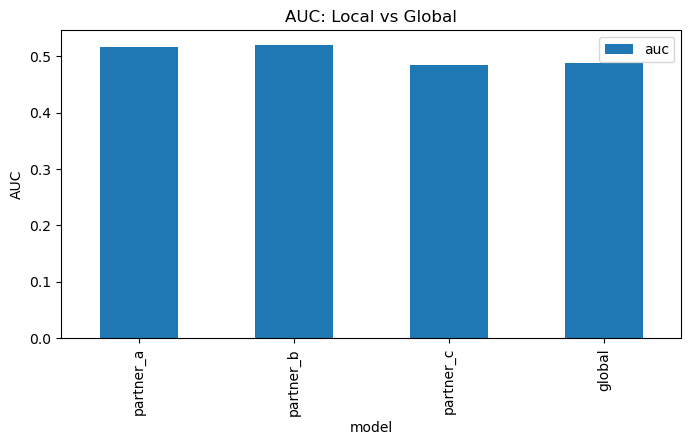

In [19]:
# 1) Copy your local results
compare_df = local_df.copy()
compare_df['model'] = compare_df['partner']

# 2) Create a one‐row DataFrame for the global model
new_row = pd.DataFrame([{'model': 'global', **global_metrics}])

# 3) Concatenate
compare_df = pd.concat([compare_df, new_row], ignore_index=True)

# 4) Plot
compare_df.plot(x='model', y='auc', kind='bar')
plt.title('AUC: Local vs Global')
plt.ylabel('AUC')
plt.show()


## 4. Attribution Heuristics Quality
Assess credit vs. actual conversion.

In [20]:
# load heuristic credits
ft = pd.read_csv('federated_mta/data/first_touch_credit.csv')
lin = pd.read_csv('federated_mta/data/linear_credit.csv')
df_conv = df_all[df_all['converted']==1][['user_id','converted']]

ft_metrics = aggregate_attribution_metrics(ft, df_conv.set_index('user_id')['converted'])
lin_metrics = aggregate_attribution_metrics(lin, df_conv.set_index('user_id')['converted'])

heur_df = pd.DataFrame([
    {'heuristic':'first_touch', **ft_metrics},
    {'heuristic':'linear',      **lin_metrics}
])
display(heur_df)

heur_df.plot(x='heuristic', y='credit_conversion_correlation', kind='bar')
plt.title('Heuristic Credit vs Conversion Correlation'); plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'federated_mta/data/first_touch_credit.csv'

## 5. Federated Learning with Flower (Sketch)
Below is how you’d plug in Flower for a true FL loop.  
*(Requires `flower` installed and separate `fl/server.py` & `fl/client.py`.)

In [ ]:
# SERVER SIDE (fl/server.py)
import flwr as fl

def get_parameters(server_round: int):
    # load global model parameters
    import torch
    from models.local_model import LocalModel
    model = LocalModel(input_dim=3)
    model.load_state_dict(torch.load('models/global/global_model.pth'))
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

class FederatedStrategy(fl.server.strategy.FedAvg):
    def __init__(self):
        super().__init__(fraction_fit=1.0, fraction_eval=1.0)
    def evaluate(self, parameters, config):
        # (Reuse evaluation code)
        return 0.0, {}

if __name__ == "__main__":
    fl.server.start_server(server_address="0.0.0.0:8080", strategy=FederatedStrategy(), config={"num_rounds":3})

In [ ]:
# CLIENT SIDE (fl/client.py)
import flwr as fl
import torch
from models.local_model import LocalModel, extract_features
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd, joblib

class MTAClient(fl.client.NumPyClient):
    def __init__(self, partner: str):
        self.partner = partner
        self.model = LocalModel(input_dim=3)
        self.scaler = joblib.load(f"models/local/{partner}_scaler.pkl")
        df = pd.read_csv(f"data/{partner}.csv")
        X, y = extract_features(df)
        X = self.scaler.transform(X.values)
        self.train_loader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32),
                                                     torch.tensor(y.values, dtype=torch.long)),
                                       batch_size=32, shuffle=True)

    def get_parameters(self):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        # set parameters
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.model.load_state_dict(state_dict)
        # train locally
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        for X_batch, y_batch in self.train_loader:
            optimizer.zero_grad()
            outputs = self.model(X_batch)
            loss = torch.nn.CrossEntropyLoss()(outputs, y_batch)
            loss.backward()
            optimizer.step()
        return self.get_parameters(), len(self.train_loader.dataset), {}

    def evaluate(self, parameters, config):
        # similar to fit but on test set
        return 0.0, len(self.train_loader.dataset), {}

if __name__ == "__main__":
    import sys
    partner = sys.argv[1]
    fl.client.start_numpy_client(server_address="0.0.0.0:8080", client=MTAClient(partner))

## 6. Differential Privacy with Opacus
Wrap your local training optimizer to add DP noise.

In [ ]:
from opacus import PrivacyEngine

# Inside client.fit or train_local_model:
privacy_engine = PrivacyEngine(
    model,
    batch_size=32,
    sample_size=len(self.train_loader.dataset),
    alphas=[10, 100],
    noise_multiplier=1.0,
    max_grad_norm=1.0,
)
privacy_engine.attach(optimizer)

# Now optimizer.step() will automatically add noise
# At end, you can inspect privacy_engine.accountant.get_epsilon(target_delta)